In [77]:
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate -U -qq ## NEW LINES ##
  basepath = '/content/drive/MyDrive/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


# New libraries introduced in this notebook
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, Value, ClassLabel, Features
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, DistilBertTokenizer
from transformers import AutoModelForSequenceClassification,  DistilBertModel
from transformers import AutoConfig, DistilBertConfig
from transformers import pipeline
import wandb

In [79]:
base_folder = Path(basepath)
data_folder = base_folder/'datasets'
model_folder = base_folder/'models'
custom_functions = base_folder/'custom-functions'
model_folder.mkdir(exist_ok=True, parents = True)

In [80]:
train_df = pd.read_csv(data_folder/'train_twitter.csv')

test_df = pd.read_csv(data_folder/'test_twitter.csv')

In [5]:
labels = [label for label in train_df.columns if label not in ["Tweet","ID"]]
id2labels = {idx:label for idx, label in enumerate(labels)}
labels2id = {v:k for k,v in id2labels.items()}
labels2id

{'anger': 0,
 'anticipation': 1,
 'disgust': 2,
 'fear': 3,
 'joy': 4,
 'love': 5,
 'optimism': 6,
 'pessimism': 7,
 'sadness': 8,
 'surprise': 9,
 'trust': 10}

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_set, valid_set = train_test_split(train_df, test_size=0.2, random_state=42)

In [8]:
train_text = train_set['Tweet'].tolist()
train_label = train_set.drop(columns=['ID','Tweet']).to_numpy().astype(float)
valid_text = valid_set['Tweet'].tolist()
valid_label = valid_set.drop(columns=['ID','Tweet']).to_numpy().astype(float)

In [9]:
train_text


["Going to get myself a copy of @StephenKing's CUJO for an upcoming project that I can't talk about just yet.  #amwriting",
 "@carysmithwriter @Maria_Savva @RealRockAndRoll We're the least known band in the World, but so glad you asked #muchlove ",
 'Unruly kids at 8am in the morning #nothanks ripping the flower beds up by the roots while their parents watch #shocking',
 "Ok but I just got called a 'White Devil' on the train and I didnt know whether to laugh or be offended",
 '@SXMUrbanView @karenhunter @CousinSyl you are so wrong for this!needed levity after that recording',
 "Even a pencil✏ never #stayed  with me until it's #end ⚫ 😞",
 "@pottermore : I can't find my patronus, the website doesn't work, I can't even see the questions.... #sadness...",
 "Pride and Prejudice is a modern day Keeping up with the Kardashians' - @howsyourdaybin .............I've never been so offended in my life",
 'Wish I could convince the rest of my children to go to their fucking preschool and elementary

In [10]:
train_label

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       ...,
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
test_text = test_df['Tweet'].tolist()
test_label = test_df.drop(columns=['ID','Tweet']).to_numpy()
test_label = np.where(test_label == "NONE",0,test_label).astype(float)

In [12]:
test_label

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
test_text

['@Adnan__786__ @AsYouNotWish Dont worry Indian army is on its ways to dispatch all Terrorists to Hell',
 'Academy of Sciences, eschews the normally sober tone of scientific papers and calls the massive loss of wildlife a “biological annihilation',
 'I blew that opportunity -__- #mad',
 'This time in 2 weeks I will be 30... 😥',
 '#Deppression is real. Partners w/ #depressed people truly dont understand the depth in which they affect us. Add in #anxiety &amp;makes it worse',
 '@POLITICOEurope Interesting choice of words... Are you confirming that governments fund #terrorism? Bit of an open door, but still...',
 '@ananavarro CNN should, for sure 😀',
 'Distance yourself once stretched by your friends impose! #serious #loveyou #notseriously',
 'Be happy. Be confident. Be kind.\\n\\n #KissablesLoveSMShopmag\\nAllOutDenimFor KISSMARC',
 'My visit to hospital for care triggered #trauma from accident 20+yrs ago and image of my dead brother in it. Feeling symptoms of #depression',
 "Thanks to D

In [14]:
test_label

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Create Huggingface DataSet

In [15]:
trainset = Dataset.from_dict({
    'texts': train_text,
    'labels': train_label
})

validset = Dataset.from_dict({
    'texts': valid_text,
    'labels': valid_label
})

testset = Dataset.from_dict({
    'texts': test_text,
    'labels': test_label
})

In [16]:
trainset

Dataset({
    features: ['texts', 'labels'],
    num_rows: 6179
})

In [17]:
trainset.features

{'texts': Value(dtype='string', id=None),
 'labels': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None)}

In [18]:
trainset.features['labels']

Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None)

In [19]:
trainset[1]

{'texts': "@carysmithwriter @Maria_Savva @RealRockAndRoll We're the least known band in the World, but so glad you asked #muchlove ",
 'labels': [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]}

In [20]:
trainset[0]['texts']

"Going to get myself a copy of @StephenKing's CUJO for an upcoming project that I can't talk about just yet.  #amwriting"

In [21]:
 trainset[1]['labels']

[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]

In [22]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [23]:
# Create function for Tokenizer

# Create function for Tokenizer

In [24]:
max_length = 128

In [25]:
def tokenize_fn(batch):
    return tokenizer(text = batch["texts"], truncation=True, padding="max_length", return_tensors="pt",max_length = 128)

In [26]:
tokenized_traindataset= trainset.map(tokenize_fn, batched=True)
tokenized_validdataset= validset.map(tokenize_fn, batched=True)
tokenized_testdataset= testset.map(tokenize_fn, batched=True)

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [27]:
tokenized_traindataset

Dataset({
    features: ['texts', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 6179
})

In [28]:
tokenized_traindataset = tokenized_traindataset.remove_columns(['texts'])
tokenized_validdataset = tokenized_validdataset.remove_columns(['texts'])
tokenized_testdataset = tokenized_testdataset.remove_columns(['texts'])

In [29]:
tokenized_traindataset.set_format(type='torch')
tokenized_validdataset.set_format(type='torch')
tokenized_testdataset.set_format(type='torch')

In [30]:
tokenized_traindataset[1]

{'labels': tensor([0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]),
 'input_ids': tensor([  101,  1030, 20533, 21405, 15994,  1030,  3814,  1035,  7842,  2615,
          3567,  1030,  2613, 16901,  5685, 28402,  2057,  1005,  2128,  1996,
          2560,  2124,  2316,  1999,  1996,  2088,  1010,  2021,  2061,  5580,
          2017,  2356,  1001,  2172, 14301,  2063,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,   

In [31]:
tokenized_traindataset.features

{'labels': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

# Model Training

## Download pre-trained model

In [32]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels = 11,problem_type = "multi_label_classification", id2label = id2labels , label2id = labels2id)
config = AutoConfig.from_pretrained(checkpoint)
config.id2label = id2labels
config.label2id = labels2id
model.config = config

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Compute Metrics

In [33]:
accuracy_metric = evaluate.load("accuracy",'multilabel' )
f1_metric = evaluate.load("f1",'multilabel')

def compute_metrics(eval_pred):

    logits, labels = eval_pred
    # predictions = (logits > 0).astype(int).reshape(-1, 11)
    predictions = (logits > 0).astype(int)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1_macro = f1_metric.compute(predictions=predictions, references=labels, average='macro')
    f1_micro = f1_metric.compute(predictions=predictions, references=labels, average='micro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy':accuracy['accuracy']}


# Train Args

In [34]:
# Define the directory where model checkpoints will be saved
run_name = "HW6/bert"
base_folder = Path(basepath)
model_folder = base_folder / "models"/run_name
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=5,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    # auto_find_batch_size=True,
    weight_decay=0.1,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-4,# Step size for the optimizer during training
    warmup_steps=50,  # Number of steps to warm up the learning rate
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=10,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases

    fp16=True,


)


# Initialize Trainer

In [35]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_traindataset,
    eval_dataset=tokenized_validdataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


# Setup wand

In [36]:
!wandb login 75a22b5a5c4de4706fb1be6e842e13687283d10c
%env WANDB_PROJECT = nlp_course_spring_2024-HW

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
env: WANDB_PROJECT=nlp_course_spring_2024-HW


# Training and Validation

In [37]:
trainer.train()

wandb: Currently logged in as: samanojvan (manojcompany). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
20,0.593100,0.523984,0.000000,0.000000,0.023948
40,0.475800,0.469025,0.000000,0.000000,0.023948
60,0.400600,0.398464,0.499575,0.238635,0.162460
80,0.353700,0.356257,0.595981,0.372850,0.203883
100,0.341700,0.343030,0.613471,0.374709,0.216828
120,0.293700,0.330005,0.627685,0.401989,0.238188
140,0.288100,0.324185,0.643126,0.455199,0.237540
160,0.257700,0.323292,0.650180,0.456739,0.247896
180,0.249700,0.323575,0.648969,0.468975,0.240129
200,0.239200,0.324539,0.651811,0.467892,0.240777


TrainOutput(global_step=245, training_loss=0.3362087512502865, metrics={'train_runtime': 86.1798, 'train_samples_per_second': 358.495, 'train_steps_per_second': 2.843, 'total_flos': 1023309287427840.0, 'train_loss': 0.3362087512502865, 'epoch': 5.0})

In [38]:
evaluated_results = trainer.evaluate(tokenized_validdataset)

In [39]:
evaluated_results

{'eval_loss': 0.32490721344947815,
 'eval_f1_micro': 0.6571865443425077,
 'eval_f1_macro': 0.49772937341705153,
 'eval_accuracy': 0.24983818770226537,
 'eval_runtime': 0.9304,
 'eval_samples_per_second': 1660.576,
 'eval_steps_per_second': 13.972,
 'epoch': 5.0}

In [40]:
wandb.log({"eval_accuracy": evaluated_results["eval_accuracy"], "eval_loss": evaluated_results["eval_loss"], "eval_f1_micro": evaluated_results["eval_f1_micro"],"eval_f1_macro":evaluated_results["eval_f1_macro"]})

In [41]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 240.


# Check Confusion Matrix

In [42]:
valid_output = trainer.predict(tokenized_validdataset)

In [43]:
predictions_valid = (valid_output.predictions > 0).astype(int)
labels_valid = valid_output.label_ids.astype(int)

In [44]:
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score

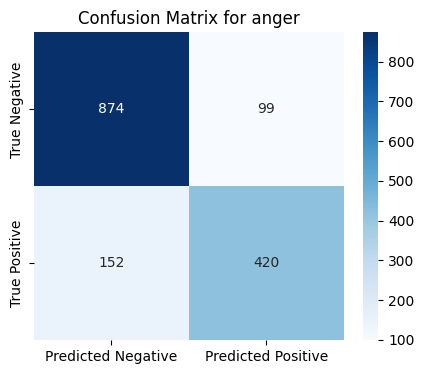

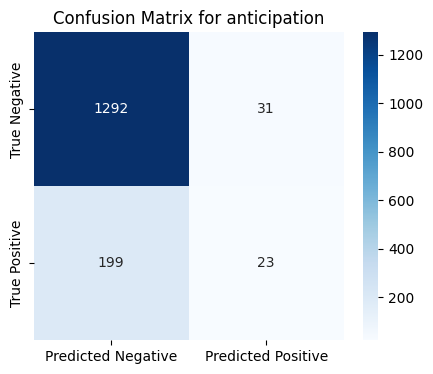

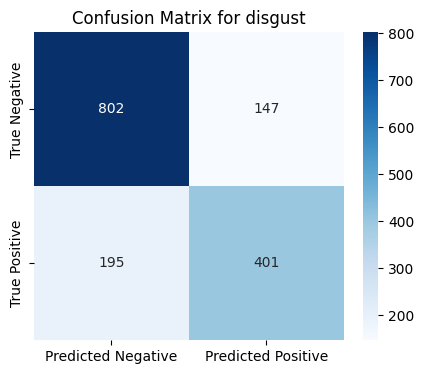

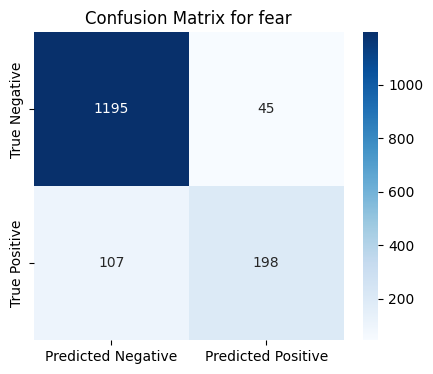

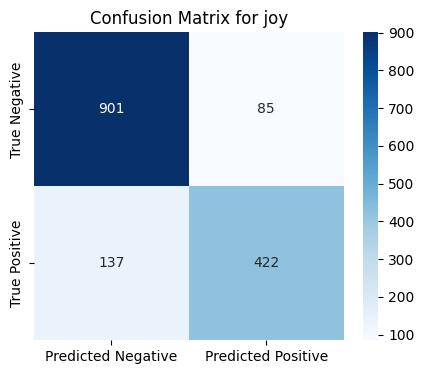

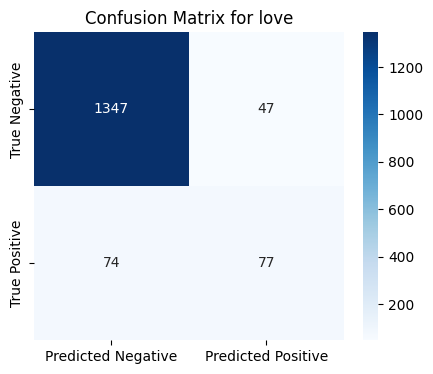

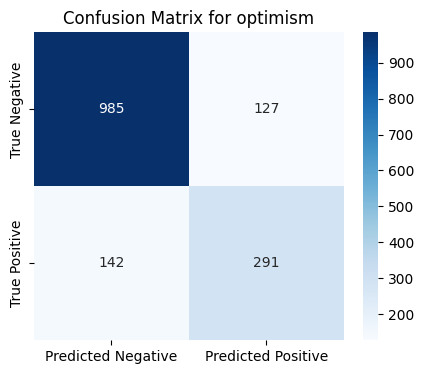

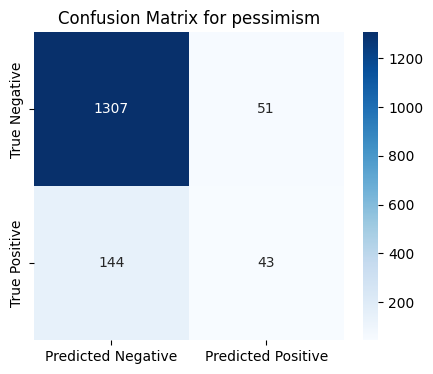

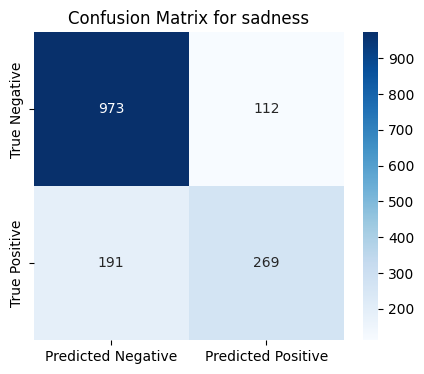

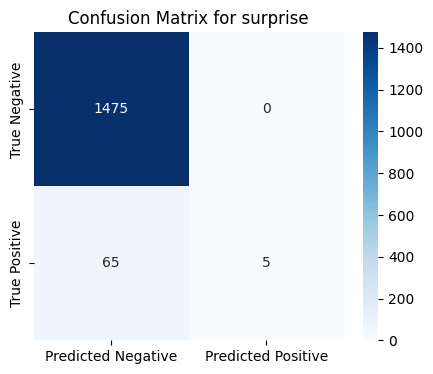

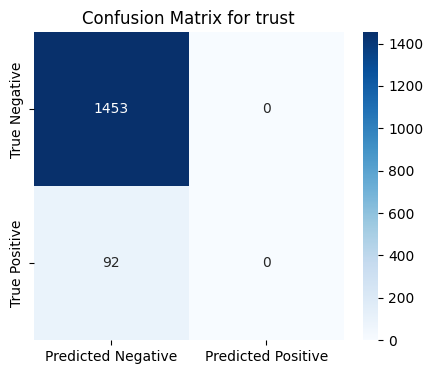

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


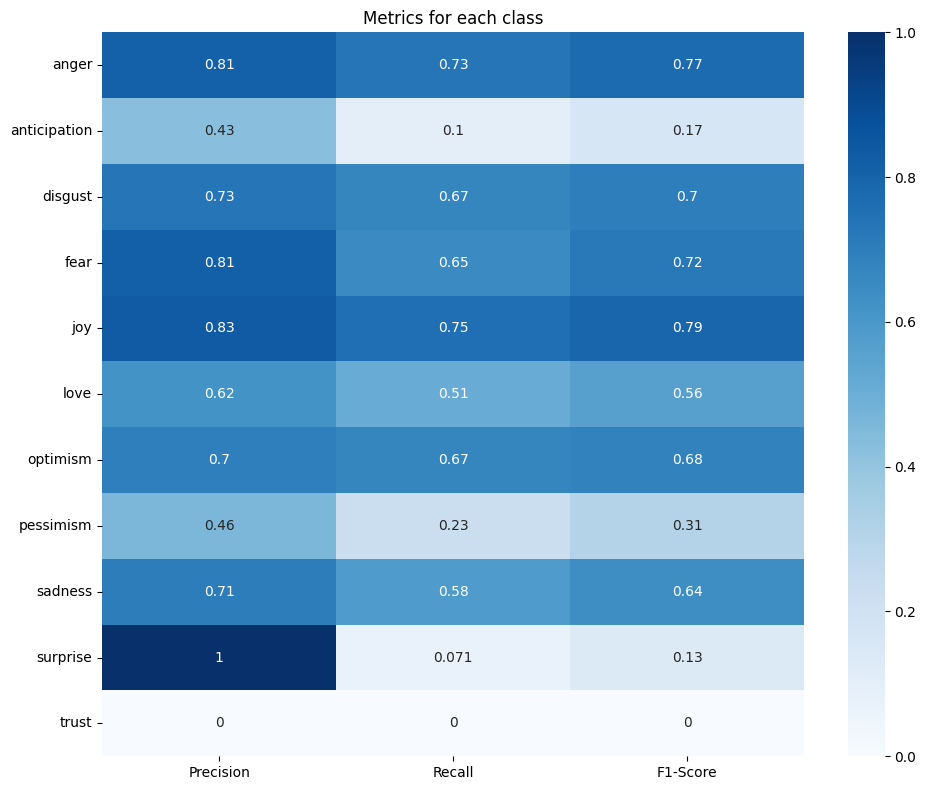

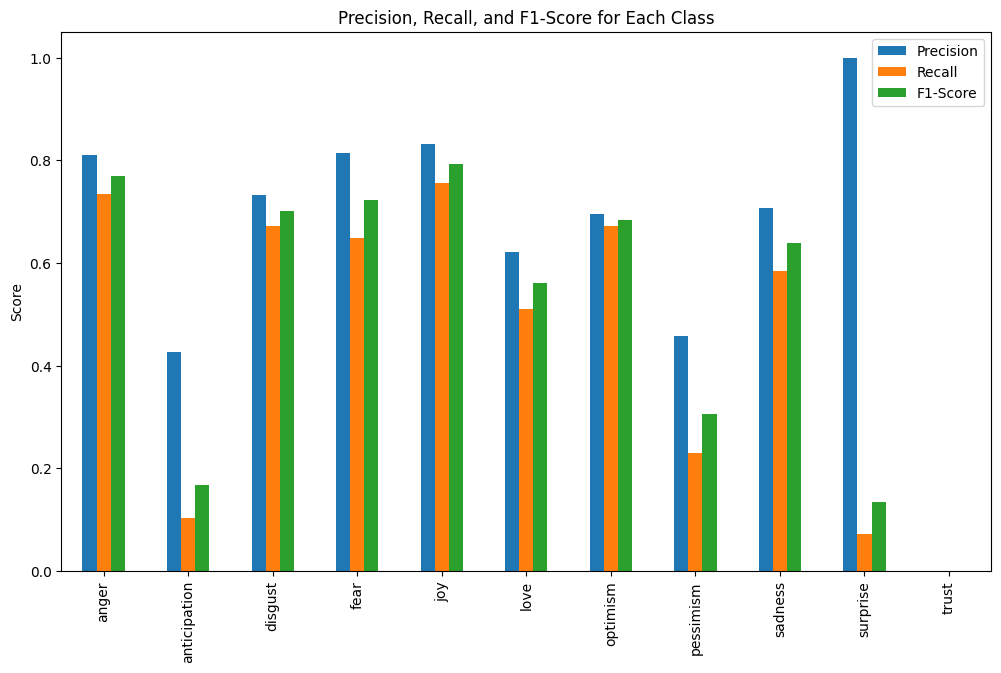

In [45]:
# from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score

# Sample data
y_true = labels_valid
y_pred = predictions_valid
class_names = labels

mcm = multilabel_confusion_matrix(y_true, y_pred,)

# 1. Individual Heatmaps
for idx, matrix in enumerate(mcm):
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['True Negative', 'True Positive'])
    plt.title(f'Confusion Matrix for {class_names[idx]}')
    plt.show()

# 2. Aggregate Metrics Heatmap
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
}, index=class_names)

plt.figure(figsize=(10, 8))
# sns.heatmap(metrics_df, annot=True, cmap='Blues')
# plt.title('Metrics for each class')
# plt.show()

ax = sns.heatmap(metrics_df, annot=True, cmap='Blues')
plt.title('Metrics for each class')
plt.tight_layout()  # Adjust layout to not cut off edges

# Log the heatmap to wandb
wandb.log({"Metrics Heatmap": wandb.Image(ax.get_figure())})
plt.show()

# 3. Histogram of Metrics
metrics_df.plot(kind='bar', figsize=(12, 7))
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.show()

# Performance on Test set

In [46]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/drive/MyDrive/data/models/HW6/bert/checkpoint-240'

In [47]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Training Arguments

In [48]:
training_args = TrainingArguments(
    output_dir=str(model_folder),
    per_device_eval_batch_size=8,
    do_train=False,
    do_eval=True,
    report_to='wandb',
    run_name=run_name
)

Instantiate Trainer

In [49]:
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_testdataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Evaluate using Trainer

In [50]:
test_results= trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [51]:
test_results

{'eval_loss': 0.47316354513168335,
 'eval_f1_micro': 0.0,
 'eval_f1_macro': 0.0,
 'eval_accuracy': 0.039889536667689476,
 'eval_runtime': 4.6028,
 'eval_samples_per_second': 708.054,
 'eval_steps_per_second': 88.642}

In [52]:
wandb.log({"test_accuracy": test_results["eval_accuracy"], "test_loss": test_results["eval_loss"], "test_f1_micro": test_results["eval_f1_micro"], "test_f1_macro": test_results["eval_f1_macro"]})

In [53]:
test_output = trainer.predict(tokenized_testdataset)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [54]:
test_output

PredictionOutput(predictions=array([[ 0.98535156, -2.2597656 ,  0.6489258 , ..., -2.3828125 ,
        -3.2089844 , -3.6152344 ],
       [ 0.74853516, -2.5722656 ,  0.81347656, ...,  0.1986084 ,
        -4.078125  , -5.171875  ],
       [ 2.6699219 , -3.9375    ,  2.3925781 , ...,  1.125     ,
        -3.9101562 , -5.4296875 ],
       ...,
       [ 3.4667969 , -2.8339844 ,  2.1308594 , ..., -2.1445312 ,
        -3.28125   , -4.390625  ],
       [-4.3398438 , -2.7792969 , -4.3945312 , ..., -3.3535156 ,
        -3.0488281 , -1.9326172 ],
       [ 1.0771484 , -1.9638672 ,  0.28686523, ..., -2.6230469 ,
        -2.4648438 , -3.6855469 ]], dtype=float32), label_ids=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), metrics={'test_loss': 0.47316354513168335, 'test_f1_micro': 0.0, 'test_f1_m

In [69]:
test_preds = np.argmax(test_output.predictions, axis=1)
test_labels = np.array(test_output.label_ids)

In [70]:
test_output.predictions


array([[ 0.98535156, -2.2597656 ,  0.6489258 , ..., -2.3828125 ,
        -3.2089844 , -3.6152344 ],
       [ 0.74853516, -2.5722656 ,  0.81347656, ...,  0.1986084 ,
        -4.078125  , -5.171875  ],
       [ 2.6699219 , -3.9375    ,  2.3925781 , ...,  1.125     ,
        -3.9101562 , -5.4296875 ],
       ...,
       [ 3.4667969 , -2.8339844 ,  2.1308594 , ..., -2.1445312 ,
        -3.28125   , -4.390625  ],
       [-4.3398438 , -2.7792969 , -4.3945312 , ..., -3.3535156 ,
        -3.0488281 , -1.9326172 ],
       [ 1.0771484 , -1.9638672 ,  0.28686523, ..., -2.6230469 ,
        -2.4648438 , -3.6855469 ]], dtype=float32)

In [71]:
test_preds

array([3, 2, 0, ..., 0, 4, 0])

In [56]:
wandb.finish()


eval/accuracy,▁▁▅▆▇█▇██████▁
eval/f1_macro,▁▁▄▆▆▇▇▇█████▁
eval/f1_micro,▁▁▆▇█████████▁
eval/loss,█▆▄▂▂▁▁▁▁▁▁▁▁▆
eval/runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁█
eval/samples_per_second,▇██▇████████▇▁
eval/steps_per_second,▁▁▁▁▁▁▁▁▁▁▁▁▁█
eval_accuracy,▁
eval_f1_macro,▁
eval_f1_micro,▁
eval_loss,▁


In [57]:
test_output

PredictionOutput(predictions=array([[ 0.98535156, -2.2597656 ,  0.6489258 , ..., -2.3828125 ,
        -3.2089844 , -3.6152344 ],
       [ 0.74853516, -2.5722656 ,  0.81347656, ...,  0.1986084 ,
        -4.078125  , -5.171875  ],
       [ 2.6699219 , -3.9375    ,  2.3925781 , ...,  1.125     ,
        -3.9101562 , -5.4296875 ],
       ...,
       [ 3.4667969 , -2.8339844 ,  2.1308594 , ..., -2.1445312 ,
        -3.28125   , -4.390625  ],
       [-4.3398438 , -2.7792969 , -4.3945312 , ..., -3.3535156 ,
        -3.0488281 , -1.9326172 ],
       [ 1.0771484 , -1.9638672 ,  0.28686523, ..., -2.6230469 ,
        -2.4648438 , -3.6855469 ]], dtype=float32), label_ids=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), metrics={'test_loss': 0.47316354513168335, 'test_f1_micro': 0.0, 'test_f1_m

In [58]:
test_output.predictions

array([[ 0.98535156, -2.2597656 ,  0.6489258 , ..., -2.3828125 ,
        -3.2089844 , -3.6152344 ],
       [ 0.74853516, -2.5722656 ,  0.81347656, ...,  0.1986084 ,
        -4.078125  , -5.171875  ],
       [ 2.6699219 , -3.9375    ,  2.3925781 , ...,  1.125     ,
        -3.9101562 , -5.4296875 ],
       ...,
       [ 3.4667969 , -2.8339844 ,  2.1308594 , ..., -2.1445312 ,
        -3.28125   , -4.390625  ],
       [-4.3398438 , -2.7792969 , -4.3945312 , ..., -3.3535156 ,
        -3.0488281 , -1.9326172 ],
       [ 1.0771484 , -1.9638672 ,  0.28686523, ..., -2.6230469 ,
        -2.4648438 , -3.6855469 ]], dtype=float32)

In [59]:
preds = test_output.predictions

In [60]:
import torch

In [61]:
preds = torch.tensor(preds)

predictions to probabilty

In [62]:
def conversion(predictions, threshold=0.25):
    probs = torch.sigmoid(torch.Tensor(predictions))
    return np.where(probs >= threshold, 1, 0)

In [63]:
test_pred_output = conversion(preds)


# Model Inference

In [64]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
custom_pipeline = pipeline(
    task="text-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device=0)

In [65]:
map_labels = []
for predictions in test_pred_output:
    map_row = [label for label, pred in zip(labels, predictions) if pred == 1]
    map_labels.append(map_row)

In [66]:
print(map_labels[0:5])

[['anger', 'disgust', 'fear'], ['anger', 'disgust', 'sadness'], ['anger', 'disgust', 'sadness'], ['anticipation', 'joy', 'optimism'], ['disgust', 'fear', 'pessimism', 'sadness']]


In [72]:
test_df[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
       'optimism', 'pessimism', 'sadness', 'surprise', 'trust']] = test_pred_output

In [73]:
test_pred_output

array([[1, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 1, 0, 0],
       [1, 0, 1, ..., 1, 0, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0]])

In [74]:
test_df.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,1,0,1,1,0,0,0,0,0,0,0
1,2018-03739,"Academy of Sciences, eschews the normally sobe...",1,0,1,0,0,0,0,0,1,0,0
2,2018-00385,I blew that opportunity -__- #mad,1,0,1,0,0,0,0,0,1,0,0
3,2018-03001,This time in 2 weeks I will be 30... 😥,0,1,0,0,1,0,1,0,0,0,0
4,2018-01988,#Deppression is real. Partners w/ #depressed p...,0,0,1,1,0,0,0,1,1,0,0


In [75]:
test_df.drop(["Tweet"],axis =1, inplace = True)

In [76]:
test_df.to_csv(data_folder/"bert-test.csv")